<h1 style="font-family: 'Poppins', sans-serif; color: #afc3cc; font-size: 36px; text-align: center;">RAINFALL PREDICTION</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score,\
                            precision_score, recall_score, roc_curve, make_scorer, \
                            roc_auc_score, auc, plot_roc_curve, plot_precision_recall_curve, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

from xgboost import XGBClassifier


from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

from sklearn.feature_selection import RFECV

import pickle
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

SEED = 42

In [40]:
df = pd.read_csv('weatherAUS.csv')
pd.set_option("display.max_columns", None)

In [168]:
df.dropna(inplace=True)

### Data Preprocessing/Feature Engineering

In [169]:
df['Month']=pd.to_datetime(df.Date, format="%Y/%m/%d").dt.month
df['Month'] = pd.to_datetime(df['Month'], format='%m').dt.month_name().str.slice(stop=3)

In [170]:
df.drop(['Date'], axis=1,inplace=True)

In [171]:
#Dropping highly correlated independent variables
df.drop(['Pressure3pm', 'Temp9am'],axis=1)


,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Cloud9am,Cloud3pm,Temp3pm,RainToday,RainTomorrow,Month
6049,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,SW,6.0,20.0,20.0,13.0,1006.3,2.0,5.0,33.4,No,No,Jan
6050,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,SSE,19.0,19.0,30.0,8.0,1012.9,1.0,1.0,27.0,No,No,Jan
6052,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,NNW,30.0,15.0,42.0,22.0,1012.3,1.0,6.0,34.9,No,No,Jan
6053,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,WSW,6.0,6.0,37.0,22.0,1012.7,1.0,5.0,35.6,No,No,Jan
6054,Cobar,24.2,41.0,0.0,11.2,8.4,WNW,35.0,NW,WNW,17.0,13.0,19.0,15.0,1010.7,1.0,6.0,37.6,No,No,Jan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142298,Darwin,19.3,33.4,0.0,6.0,11.0,ENE,35.0,SE,NE,9.0,20.0,63.0,32.0,1013.9,0.0,1.0,32.3,No,No,Jun
142299,Darwin,21.2,32.6,0.0,7.6,8.6,E,37.0,SE,SE,13.0,11.0,56.0,28.0,1014.6,7.0,0.0,32.0,No,No,Jun
142300,Darwin,20.7,32.8,0.0,5.6,11.0,E,33.0,E,W,17.0,11.0,46.0,23.0,1015.3,0.0,0.0,32.1,No,No,Jun
142301,Darwin,19.5,31.8,0.0,6.2,10.6,ESE,26.0,SE,NNW,9.0,17.0,62.0,58.0,1014.9,1.0,1.0,29.2,No,No,Jun


### Feature Extraction

In [172]:
le = LabelEncoder()
df['RainTomorrow']= le.fit_transform(df['RainTomorrow'])

In [112]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'No': 0, 'Yes': 1}


In [173]:
df = pd.get_dummies(df, columns= [i for i in df.columns if df[i].dtypes=='object'],drop_first=True)

In [174]:
X = df.drop(['RainTomorrow'], axis=1) # input
y = df['RainTomorrow']

In [115]:
X.shape

(123710, 122)

In [25]:
y.shape

(56420,)

In [9]:
df.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainTomorrow', 'Location_Brisbane',
       'Location_Cairns', 'Location_Canberra', 'Location_Cobar',
       'Location_CoffsHarbour', 'Location_Darwin', 'Location_Hobart',
       'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Mildura',
       'Location_Moree', 'Location_MountGambier', 'Location_NorfolkIsland',
       'Location_Nuriootpa', 'Location_Perth', 'Location_PerthAirport',
       'Location_Portland', 'Location_Sale', 'Location_Sydney',
       'Location_SydneyAirport', 'Location_Townsville', 'Location_WaggaWagga',
       'Location_Watsonia', 'Location_Williamtown', 'Location_Woomera',
       'WindGustDir_ENE', 'WindGustDir_ESE', 'WindGustDir_N', 'WindGustDir_NE',
       'WindGustDir_NNE', 'WindGustDir_NNW', 'WindGustDir_NW', 

### Splitting data into training data and testing data

In [175]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X ,y, 
                                                    test_size = 0.2, 
                                                    shuffle=True, 
                                                    stratify=y,
                                                    random_state=SEED)

### Feature Scaling

In [117]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

### Baseline Model - Logistic Regression

In [119]:
logreg=LogisticRegression(random_state=SEED)

In [120]:
scoring = {'accuracy': 'accuracy',
           'f1' : 'f1',
           'precision (class 0)': make_scorer(precision_score, average = None, labels = [0]), 
           'precision (class 1)': make_scorer(precision_score, average = None, labels = [1]),
           'recall (class 0)': make_scorer(recall_score, average = None, labels = [0]), 
           'recall (class 1)': make_scorer(recall_score, average = None, labels = [1])}

scores = cross_validate(logreg,  X_train, y_train, cv=5, scoring=scoring)
for k in list(scores.keys())[2:]:
    print('{:19}: {:.2%} (mean), {:.2%} (std)'.format(k.strip("test_"), scores[k].mean(), scores[k].std()))

accuracy           : 85.06% (mean), 0.34% (std)
f1                 : 60.56% (mean), 0.88% (std)
precision (class 0): 87.46% (mean), 0.25% (std)
precision (class 1): 72.39% (mean), 1.55% (std)
recall (class 0)   : 94.38% (mean), 0.47% (std)
recall (class 1)   : 52.08% (mean), 1.19% (std)


In [122]:
logreg.fit(X_train,y_train)

LogisticRegression(random_state=42)

In [124]:
print("Score on Training Dataset" + str(logreg.score(X_train,y_train)))
print("Score on Test Dataset" + str(logreg.score(X_test,y_test)))

Score on Training Dataset0.8510153441029017
Score on Test Dataset0.8518846744653197


In [123]:
y_pred=logreg.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Classification report:")
print(classification_report(y_test,y_pred))

Confusion Matrix:
[[12444   754]
 [ 1753  1975]]
Classification report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     13198
           1       0.72      0.53      0.61      3728

    accuracy                           0.85     16926
   macro avg       0.80      0.74      0.76     16926
weighted avg       0.84      0.85      0.84     16926



### Evaluating Multiple Models with K-Fold Cross Validation

In [200]:
models = []
models.append(('LR', LogisticRegression(random_state=SEED)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3)))
models.append(('SVM', SVC(random_state=SEED)))
models.append(('RF', RandomForestClassifier(random_state=SEED)))
models.append(('XGBoost', XGBClassifier(objective='binary:logistic', random_state=SEED)))
models.append(('MLP', MLPClassifier(random_state=SEED)))

# evaluate each model in turn
results = []
names = []
scoring = {'accuracy': 'accuracy',
           'f1' : 'f1',
           'precision (class 0)': make_scorer(precision_score, average = None, labels = [0]), 
           'precision (class 1)': make_scorer(precision_score, average = None, labels = [1]),
           'recall (class 0)': make_scorer(recall_score, average = None, labels = [0]), 
           'recall (class 1)': make_scorer(recall_score, average = None, labels = [1]) }

for name, model in models:
    scores = cross_validate(model,  X_train_mixed, y_train_mixed, cv=3, scoring=scoring)
    for k in list(scores.keys())[2:]:
        print(name)
        print('{:19}: {:.2%} (mean), {:.2%} (std)'.format(k.strip("test_"), scores[k].mean(), scores[k].std()))


LR
accuracy           : 78.40% (mean), 0.33% (std)
LR
f1                 : 76.72% (mean), 0.36% (std)
LR
precision (class 0): 78.44% (mean), 0.31% (std)
LR
precision (class 1): 78.35% (mean), 0.37% (std)
LR
recall (class 0)   : 81.31% (mean), 0.32% (std)
LR
recall (class 1)   : 75.16% (mean), 0.36% (std)
KNN
accuracy           : 84.19% (mean), 1.33% (std)
KNN
f1                 : 84.83% (mean), 1.44% (std)
KNN
precision (class 0): 92.87% (mean), 2.71% (std)
KNN
precision (class 1): 77.68% (mean), 0.60% (std)
KNN
recall (class 0)   : 75.85% (mean), 0.17% (std)
KNN
recall (class 1)   : 93.46% (mean), 2.63% (std)
SVM
accuracy           : 78.65% (mean), 0.30% (std)
SVM
f1                 : 77.06% (mean), 0.34% (std)
SVM
precision (class 0): 78.79% (mean), 0.30% (std)
SVM
precision (class 1): 78.49% (mean), 0.32% (std)
SVM
recall (class 0)   : 81.34% (mean), 0.26% (std)
SVM
recall (class 1)   : 75.68% (mean), 0.35% (std)
RF
accuracy           : 86.76% (mean), 2.63% (std)
RF
f1              

### Hyperparameter Tuning for XGBoostClassifier

In [129]:
clf_xgb = XGBClassifier(objective='binary:logistic', random_state=SEED)
clf_xgb.fit(X_train,y_train)

[15:48:29] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

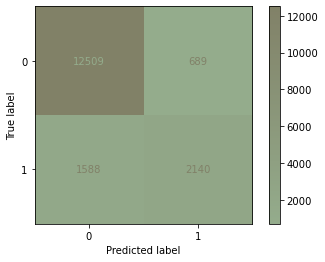

In [155]:
import matplotlib
metrics.plot_confusion_matrix(clf_xgb, X_test, y_test, 
                              cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", [lighten_color('#94ac8c', 1),lighten_color('#70705a', 0.9)]))


In [158]:
y_pred=clf_xgb.predict(X_test)
print("Confusion Matrix:")
#print(confusion_matrix(y_test,y_pred))
print("Classification report:")
print(classification_report(y_test,y_pred))

Confusion Matrix:
Classification report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     13198
           1       0.76      0.57      0.65      3728

    accuracy                           0.87     16926
   macro avg       0.82      0.76      0.78     16926
weighted avg       0.86      0.87      0.86     16926



In [159]:
print("Score on Training Dataset" + str(clf_xgb.score(X_train,y_train)))
print("Score on Test Dataset" + str(clf_xgb.score(X_test,y_test)))

Score on Training Dataset0.9242416569605509
Score on Test Dataset0.8654732364409784


In [46]:
param_grid1={
 "learning_rate"    : [0.1,0.01,0.05 ] ,
 "max_depth"        : [ 3,4,5],
 "reg_lambda" : [ 0, 1.0, 10.0 ],
 "gamma"            : [ 0,0.25,1.0],
 "scale_pos_weight" : [ 1,3,5 ]
}

In [137]:
xgb_gridsearchcv=GridSearchCV(estimator=XGBClassifier(objective='binary:logistic',
                                                      subsample=0.9,
                                                      colsample_bytree=0.5,
                                                      random_state=SEED),
                              param_grid=param_grid1,
                              scoring='f1',
                              n_jobs=-1,
                              cv=3,
                              verbose=2)

In [139]:
xgb_gridsearchcv.fit(X_train,
                     y_train, 
                     verbose=True)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[17:52:00] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=42,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=0.9,
                                     tree_method=None, val

In [52]:
xgb_gridsearchcv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.25, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=0, scale_pos_weight=1, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [146]:
xgb_gridsearchcv.best_score_

0.6750042936792079

In [147]:
xgb_gridsearchcv.best_params_

{'gamma': 1.5,
 'learning_rate': 0.1,
 'max_depth': 8,
 'reg_lambda': 1.0,
 'scale_pos_weight': 3}

In [153]:
param_grid2={
 "learning_rate"    : [0.1,0.5, 1 ] ,
 "max_depth"        : [ 5,8, 11],
 "reg_lambda" : [ 1.00],
 "gamma"            : [ 1.0, 1.5, 2.0],
 "scale_pos_weight" : [ 3 ]
}

In [154]:
xgb_gridsearchcv=GridSearchCV(estimator=XGBClassifier(objective='binary:logistic',
                                                      subsample=0.9,
                                                      colsample_bytree=0.5,
                                                      random_state=SEED),
                              param_grid=param_grid2,
                              scoring='f1',
                              n_jobs=-1,
                              cv=3)

In [155]:
xgb_gridsearchcv.fit(X_train,
                     y_train, 
                     verbose=True)

[18:14:54] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=42,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=0.9,
                                     tree_method=None, val

In [156]:
xgb_gridsearchcv.best_params_

{'gamma': 1.5,
 'learning_rate': 0.1,
 'max_depth': 8,
 'reg_lambda': 1.0,
 'scale_pos_weight': 3}

In [175]:
xgb_gridsearchcv = XGBClassifier(objective='binary:logistic', 
                        gamma=1.5,
                        learning_rate=0.1,
                        max_depth=8,
                        reg_lambda=1.0,
                        scale_pos_weight=3,
                        subsample=0.9,
                        colsample_bytree=0.5,
                        random_state=SEED)

In [176]:
xgb_gridsearchcv.fit(X_train,
            y_train, 
            verbose=True)

[17:22:36] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=1.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1.0, scale_pos_weight=3, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [177]:
print("Score on Training Dataset" + str(xgb_gridsearchcv.score(X_train,y_train)))
print("Score on Test Dataset" + str(xgb_gridsearchcv.score(X_test,y_test)))

Score on Training Dataset0.9094799210006583
Score on Test Dataset0.8419591161526645


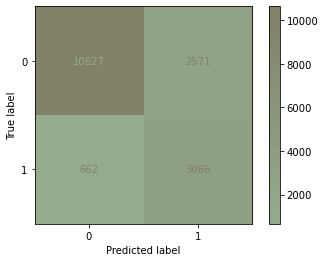

In [174]:
metrics.plot_confusion_matrix(xgb_gridsearchcv, X_test, y_test,
                             cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", [lighten_color('#94ac8c', 1),lighten_color('#70705a', 0.9)]))

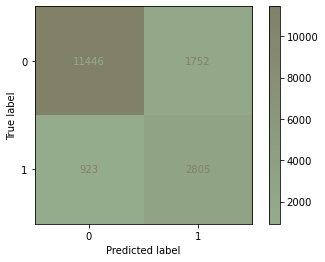

In [178]:
metrics.plot_confusion_matrix(xgb_gridsearchcv, X_test, y_test,
                             cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", [lighten_color('#94ac8c', 1),lighten_color('#70705a', 0.9)]))

In [179]:
y_pred=xgb_gridsearchcv.predict(X_test)
print("Confusion Matrix:")
#print(confusion_matrix(y_test,y_pred))
print("Classification report:")
print(classification_report(y_test,y_pred))

Confusion Matrix:
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90     13198
           1       0.62      0.75      0.68      3728

    accuracy                           0.84     16926
   macro avg       0.77      0.81      0.79     16926
weighted avg       0.86      0.84      0.85     16926



### Feature Selection - XGBoost

In [183]:
feature_importance = np.array(xgb_gridsearchcv.feature_importances_)
feature_names = np.array(X.columns)
df_feat_imp = pd.DataFrame({'feature_names':feature_names,'feature_importance':feature_importance})
feat_imp_sorted = df_feat_imp.sort_values('feature_importance', ascending=False)

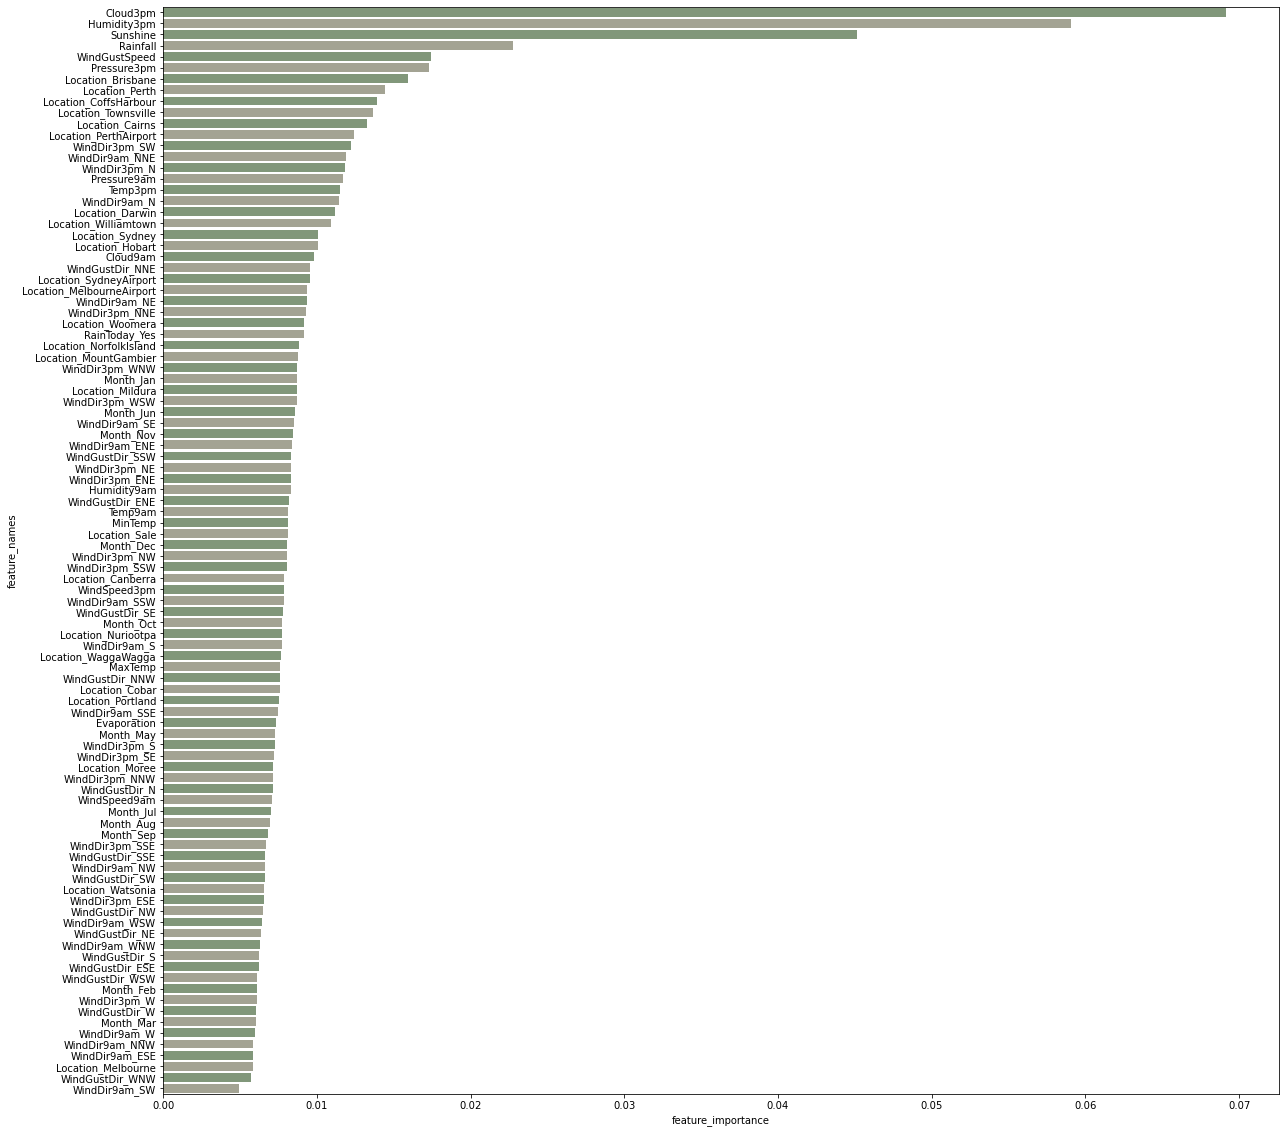

In [186]:
plt.figure(figsize=(20,20))
_ = sns.barplot(x=feat_imp_sorted['feature_importance'], y=feat_imp_sorted['feature_names'], palette=[lighten_color('#94ac8c', 1.2),lighten_color('#70705a', 0.65) ])

In [187]:
rfecv = RFECV(estimator=xgb_gridsearchcv, cv=StratifiedKFold(5), scoring='f1')
rfecv.fit(X,y)

[18:04:34] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:04:38] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:04:42] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:04:46] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[18:07:17] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:07:23] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:07:28] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:07:34] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[18:09:56] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:09:59] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:10:04] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:10:07] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[18:11:43] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:11:50] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:11:57] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:12:03] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[18:15:08] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:15:13] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:15:19] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:15:24] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[18:17:44] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:17:48] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:17:52] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:17:55] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[18:19:34] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:19:42] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:19:48] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:19:55] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[18:23:01] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:23:06] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:23:12] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:23:17] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[18:25:37] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:25:41] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:25:45] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:25:49] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[18:27:31] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:27:38] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:27:44] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:27:51] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[18:30:54] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:31:00] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:31:05] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:31:10] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[18:33:36] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:33:39] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:33:44] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:33:47] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[18:35:33] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:35:39] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:35:46] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:35:53] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[18:38:57] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:39:02] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:39:08] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:39:13] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[18:41:35] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:41:39] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:41:42] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:41:47] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[18:43:50] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:43:58] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:44:06] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:44:14] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[18:47:51] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:47:58] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:48:04] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:48:11] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=0.5, gamma=1.5, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=8, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=8, num_parallel_tree=1,
                              random_state=42, reg_alpha=0, reg_lambda=1.0,
                              scale_pos_weight=3, subsample=0.9,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None),
      scoring='f1')

In [117]:
with open('rfecv', 'wb') as f:
    pickle.dump(rfecv,f)

In [189]:
rfecv.estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=1.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1.0, scale_pos_weight=3, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [188]:
rfecv.n_features_

43

In [190]:
rfecv.ranking_

array([ 1,  1,  1,  3,  1,  1,  4,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, 28, 49,  1,  1,  1, 33,  1, 13, 15, 18,  1, 34,  1,  1, 19,  1,
        1,  1,  1,  9, 27,  1, 10,  1, 48,  1,  2,  1, 12, 46, 24, 26, 44,
       30, 31, 53, 56, 54,  1, 55,  1,  1,  1, 45, 52,  1, 36, 16, 22, 47,
       42, 37, 38, 50, 51,  1, 17,  1,  8,  1, 21, 35, 29,  1,  1, 20,  1,
       11,  1, 43, 23, 39,  7,  6,  5, 40, 41, 25, 14, 32])

In [190]:
rfecv.get_support()

array([False, False, False, False, False, False, False, False, False,
        True, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [201]:
print(np.where(rfecv.support_ == False)[0])

[19 42 47 50 53 54 55 57 61 62 67 68 70 71 72 87 89 93 94]


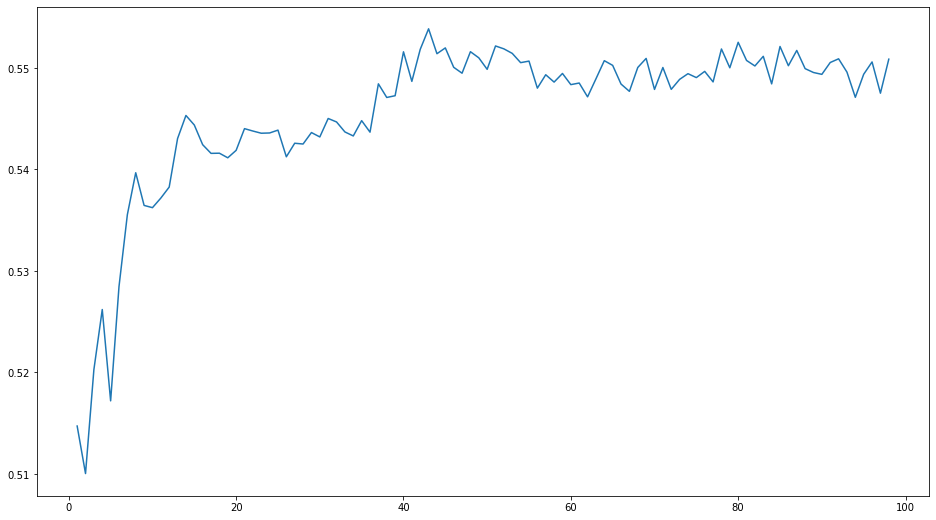

In [191]:
plt.figure(figsize=(16,9))
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [193]:
feature_index = []
dropped_feature_index = []
features = []
dropped_features = []
#column_index(X_dev_train, X_dev_train.columns.values)

for num, i in enumerate(rfecv.get_support(), start=0):
    if i == True:
        feature_index.append(str(num))
    else:
        dropped_feature_index.append(str(num))
        
for num, i in enumerate(X.columns.values, start=0):
    if str(num) in feature_index:
        features.append(X.columns.values[num])
    else:
        dropped_features.append(X.columns.values[num])

print("Features Selected: {}\n".format(len(feature_index)))
print("Features Indexes: \n{}\n".format(feature_index))
print("Feature Names: \n{}\n".format(features))
print("Dropped Features Indexes: \n{}\n".format(dropped_feature_index))
print("Dropped Feature Names: \n{}".format(dropped_features))

Features Selected: 43

Features Indexes: 
['0', '1', '2', '4', '5', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '20', '21', '22', '24', '28', '30', '31', '33', '34', '35', '36', '39', '41', '43', '45', '56', '58', '59', '60', '63', '73', '75', '77', '81', '82', '84', '86']

Feature Names: 
['MinTemp', 'MaxTemp', 'Rainfall', 'Sunshine', 'WindGustSpeed', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'Location_Brisbane', 'Location_Cairns', 'Location_CoffsHarbour', 'Location_Darwin', 'Location_Hobart', 'Location_MelbourneAirport', 'Location_NorfolkIsland', 'Location_Perth', 'Location_PerthAirport', 'Location_Sale', 'Location_Sydney', 'Location_SydneyAirport', 'Location_Townsville', 'Location_Williamtown', 'WindGustDir_ENE', 'WindGustDir_N', 'WindGustDir_NNE', 'WindDir9am_ENE', 'WindDir9am_N', 'WindDir9am_NE', 'WindDir9am_NNE', 'WindDir9am_S', 'WindDir3pm_N', 'WindDir3pm_NNE', 'WindDir3pm_NW', 'Wi

In [13]:
dropped_features = ['Location_Cobar', 'WindGustDir_ESE', 'WindGustDir_NW', 'WindGustDir_SSE', 'WindGustDir_W', 'WindGustDir_WNW', 'WindGustDir_WSW', 'WindDir9am_ESE', 'WindDir9am_NNW', 'WindDir9am_NW', 'WindDir9am_SW', 'WindDir9am_W', 'WindDir9am_WSW', 'WindDir3pm_ENE', 'WindDir3pm_ESE', 'Month_Aug', 'Month_Feb', 'Month_Mar', 'Month_May']

In [14]:
X_selected_features = X.drop(dropped_features, axis = 1)

In [15]:
X_selected_features.shape

(56420, 79)

In [16]:
X_train_selected_features, X_test_selected_features, y_train, y_test = train_test_split(X_selected_features,y, 
                                                    test_size = 0.3, 
                                                    shuffle=True, 
                                                    stratify=y,
                                                    random_state=42)

### Tune XGBoost with new dataset feature selection

In [194]:
param_grid_selected_features={
 "learning_rate"    : [0.05, 0.1,0.5, 1 ] ,
 "max_depth"        : [ 2, 5,8, 11],
 "reg_lambda" : [ 0, 1.00, 5.0],
 "gamma"            : [ 0.5, 1.0, 1.5],
 "scale_pos_weight" : [ 3 ]
}

In [195]:
xgb_gridsearchcv_selected_features=GridSearchCV(estimator=XGBClassifier(objective='binary:logistic',
                                                      subsample=0.9,
                                                      colsample_bytree=0.5,
                                                      random_state=SEED),
                              param_grid=param_grid_selected_features,
                              scoring='f1',
                              n_jobs=-1,
                              cv=5,
                              verbose=2)

In [196]:
xgb_gridsearchcv_selected_features.fit(X_train_selected_features,
                     y_train, 
                     verbose=True)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[20:05:10] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=42,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=0.9,
                                     tree_method=None, val

In [ ]:
rfecv

In [197]:
xgb_gridsearchcv_selected_features.best_params_

{'gamma': 0.5,
 'learning_rate': 0.1,
 'max_depth': 11,
 'reg_lambda': 5.0,
 'scale_pos_weight': 3}

In [198]:
xgb_gridsearchcv_selected_features.best_score_

0.6802620265840886

In [199]:
clf_xgb_selected_features = XGBClassifier(objective='binary:logistic', 
                        gamma=0.5,
                        learning_rate=0.1,
                        max_depth=11,
                        reg_lambda=5.0,
                        scale_pos_weight=3,
                        subsample=0.9,
                        colsample_bytree=0.5,
                        random_state=SEED)

In [200]:
clf_xgb_selected_features.fit(X_train_selected_features,
            y_train, 
            verbose=True)

[20:28:16] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=11,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=5.0, scale_pos_weight=3, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

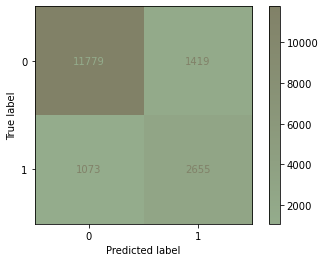

In [202]:
metrics.plot_confusion_matrix(clf_xgb_selected_features, X_test_selected_features, y_test,
                             cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", [lighten_color('#94ac8c', 1),lighten_color('#70705a', 0.9)]))

In [204]:
y_pred=clf_xgb_selected_features.predict(X_test_selected_features)
print("Confusion Matrix:")
#print(confusion_matrix(y_test,y_pred))
print("Classification report:")
print(classification_report(y_test,y_pred))

Confusion Matrix:
Classification report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.90     13198
           1       0.65      0.71      0.68      3728

    accuracy                           0.85     16926
   macro avg       0.78      0.80      0.79     16926
weighted avg       0.86      0.85      0.86     16926



In [206]:
print("Score on Training Dataset" + str(clf_xgb_selected_features.score(X_train_selected_features,y_train)))
print("Score on Test Dataset" + str(clf_xgb_selected_features.score(X_test_selected_features,y_test)))

Score on Training Dataset0.9613865397275535
Score on Test Dataset0.8527708850289496


### Running XGBoost model (hyperparameter tuned) with selected features

In [209]:
clf_xgb.fit(X_train_selected_features,
            y_train, 
            verbose=True)

[20:08:49] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=1.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1.0, scale_pos_weight=3, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

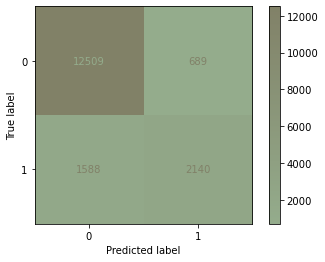

In [265]:
metrics.plot_confusion_matrix(clf_xgb, X_test, y_test,
                            cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", [lighten_color('#94ac8c', 1),lighten_color('#70705a', 0.9)]))

In [214]:
y_pred=clf_xgb.predict(X_test_selected_features)
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))
print("Classification report:")
print(classification_report(y_test,y_pred))

Confusion Matrix:
[[11488  1710]
 [  919  2809]]
Classification report:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90     13198
           1       0.62      0.75      0.68      3728

    accuracy                           0.84     16926
   macro avg       0.77      0.81      0.79     16926
weighted avg       0.86      0.84      0.85     16926



### Balancing Dataset using SMOTE

In [49]:
# Smote with all features
over = SMOTE(sampling_strategy=0.7) 
under = RandomUnderSampler(sampling_strategy=0.9) 
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
X_train_mixed, y_train_mixed = pipeline.fit_resample(X_train, y_train)

# summarize the new class distribution
counter = Counter(y_train_mixed)
print(counter)

Counter({0: 23951, 1: 21556})


In [207]:
# Smote with all selected features
over = SMOTE(sampling_strategy=0.7) 
under = RandomUnderSampler(sampling_strategy=0.9) 
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
X_train_mixed_selected_features, y_train_mixed_selected_features = pipeline.fit_resample(X_train_selected_features, y_train)

# summarize the new class distribution
counter = Counter(y_train_mixed_selected_features)
print(counter)

Counter({0: 23951, 1: 21556})


In [95]:
y_train.value_counts()

0    30795
1     8699
Name: RainTomorrow, dtype: int64

### Tune XGBoost with new dataset feature selection and smote

In [209]:
param_grid_selected_features_and_smote={
 "learning_rate"    : [0.05, 0.1,0.5, 1 ] ,
 "max_depth"        : [ 2, 5,8, 11],
 "reg_lambda" : [ 0, 1.00, 5.0],
 "gamma"            : [ 0.5, 1.0, 1.5],
 "scale_pos_weight" : [ 3 ]
}

In [210]:
xgb_gridsearchcv_selected_features_and_smote=GridSearchCV(estimator=XGBClassifier(objective='binary:logistic',
                                                      subsample=0.9,
                                                      colsample_bytree=0.5,
                                                      random_state=SEED),
                              param_grid=param_grid_selected_features_and_smote,
                              scoring='f1',
                              n_jobs=-1,
                              cv=5,
                              verbose=2)

In [230]:
xgb_gridsearchcv_selected_features_and_smote.fit(X_train_mixed_selected_features,
                     y_train_mixed_selected_features, 
                     verbose=True)

[22:03:32] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=1.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1.0, scale_pos_weight=3, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [231]:
print("Score on Training Dataset" + str(xgb_gridsearchcv_selected_features_and_smote.score(X_train_mixed_selected_features,y_train_mixed_selected_features)))
print("Score on Test Dataset" + str(xgb_gridsearchcv_selected_features_and_smote.score(X_test_selected_features,y_test)))

Score on Training Dataset0.909200782297229
Score on Test Dataset0.8074559848753398


In [235]:
y_pred=xgb_gridsearchcv_selected_features_and_smote.predict(X_test_selected_features)


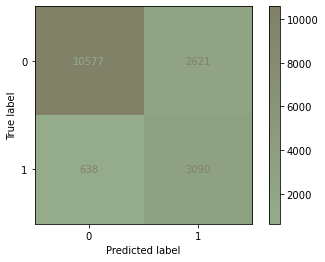

In [234]:
metrics.plot_confusion_matrix(xgb_gridsearchcv_selected_features_and_smote, X_test_selected_features, y_test,
                      cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", [lighten_color('#94ac8c', 1),lighten_color('#70705a', 0.9)]))       

In [236]:
print("Confusion Matrix:")
#print(confusion_matrix(y_test,y_pred))
print("Classification report:")
print(classification_report(y_test,y_pred))

Confusion Matrix:
Classification report:
              precision    recall  f1-score   support

           0       0.94      0.80      0.87     13198
           1       0.54      0.83      0.65      3728

    accuracy                           0.81     16926
   macro avg       0.74      0.82      0.76     16926
weighted avg       0.85      0.81      0.82     16926



In [237]:
print("Score on Training Dataset" + str(xgb_gridsearchcv_selected_features_and_smote.score(X_train_mixed_selected_features,y_train_mixed_selected_features)))
print("Score on Test Dataset" + str(xgb_gridsearchcv_selected_features_and_smote.score(X_test_selected_features,y_test)))

Score on Training Dataset0.909200782297229
Score on Test Dataset0.8074559848753398


### XGBoost (after hyperparameter tuning) with balanced data and without feature selection

In [ ]:
clf_xgb.fit(X_train_mixed, y_train_mixed)

In [ ]:
print(classification_report(y_test, clf_xgb.predict(X_test)))

### XGBoost (after hyperparameter tuning) with balanced data and with feature selection

In [ ]:
# SMOTE with selected features
over = SMOTE(sampling_strategy=0.7) 
under = RandomUnderSampler(sampling_strategy=0.9) 
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
X_train_mixed_selected_features, y_train_mixed_selected_features = pipeline.fit_resample(X_train_selected_features, y_train)

# summarize the new class distribution
counter = Counter(y_train_mixed)
print(counter)

In [218]:
scoring = {'accuracy': 'accuracy',
           'f1':'f1',
           'precision (class 0)': make_scorer(precision_score, average = None, labels = [0]), 
           'precision (class 1)': make_scorer(precision_score, average = None, labels = [1]),
           'recall (class 0)': make_scorer(recall_score, average = None, labels = [0]), 
           'recall (class 1)': make_scorer(recall_score, average = None, labels = [1])}

scores = cross_validate(clf_xgb,  X_train_mixed_selected_features, y_train_mixed_selected_features, cv=5, scoring=scoring)
scores_to_print = list(scores.keys())[2:]

for k in scores_to_print:
    print('{:19}: {:.2%} (mean), {:.2%} (std)'.format(k.strip("test_"), scores[k].mean(), scores[k].std()))

[20:15:26] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:15:29] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:15:31] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:15:34] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [ ]:
clf_xgb.fit(X_train_mixed_selected_features, y_train_mixed_selected_features)

In [221]:
print(classification_report(y_test, clf_xgb.predict(X_test_selected_features)))

              precision    recall  f1-score   support

           0       0.94      0.80      0.86     13198
           1       0.54      0.83      0.65      3728

    accuracy                           0.80     16926
   macro avg       0.74      0.81      0.76     16926
weighted avg       0.85      0.80      0.82     16926



### Running the balanced dataset with other models

In [238]:
# run with balanced dataset
models = []
models.append(('LR', LogisticRegression(random_state=SEED)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=3)))
models.append(('SVM', SVC(random_state=SEED)))
models.append(('RF', RandomForestClassifier(random_state=SEED)))
models.append(('MLP', MLPClassifier(random_state=SEED)))

# evaluate each model in turn
results = []
names = []
scoring = 'recall'

for name, model in models:
    cv_results = cross_val_score(model, 
                                 X_train_mixed, 
                                 y_train_mixed, 
                                 cv=5, 
                                 scoring=scoring,
                                 n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    msg = "{:3}: Mean Recall score {:.4f}% XGBoost Recall Score: 0.82 ".format(name, cv_results.mean()*100)
    print(msg)

LR : Mean Recall score 76.9438% XGBoost Recall Score: 0.82 
KNN: Mean Recall score 95.4725% XGBoost Recall Score: 0.82 
SVM: Mean Recall score 73.1768% XGBoost Recall Score: 0.82 
RF : Mean Recall score 84.4924% XGBoost Recall Score: 0.82 
MLP: Mean Recall score 64.3924% XGBoost Recall Score: 0.82 


Text(0.5, 1.0, 'Precision-Recall curve')

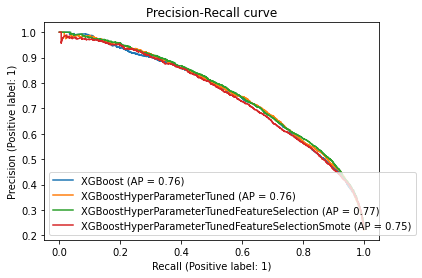

In [254]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

plot_precision_recall_curve(clf_xgb, X_test, y_test, ax = plt.gca(),name = "XGBoost")

plot_precision_recall_curve(xgb_gridsearchcv, X_test, y_test, ax = plt.gca(),name = "XGBoostHyperParameterTuned")

plot_precision_recall_curve(clf_xgb_selected_features, X_test_selected_features, y_test, ax = plt.gca(),name = "XGBoostHyperParameterTunedFeatureSelection")

plot_precision_recall_curve(xgb_gridsearchcv_selected_features_and_smote, X_test_selected_features, y_test, ax = plt.gca(),name = "XGBoostHyperParameterTunedFeatureSelectionSmote")

plt.title('Precision-Recall curve')

Text(0.5, 1.0, 'ROC-AUC curve')

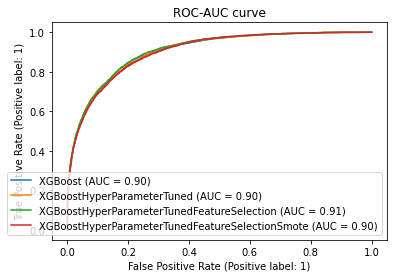

In [263]:
metrics.plot_roc_curve(clf_xgb, X_test, y_test, ax = plt.gca(), name = "XGBoost")
metrics.roc_auc_score(y_test, clf_xgb.predict(X_test), average=None) 

metrics.plot_roc_curve(xgb_gridsearchcv, X_test, y_test, ax = plt.gca(), name = "XGBoostHyperParameterTuned")
metrics.roc_auc_score(y_test, xgb_gridsearchcv.predict(X_test), average=None) 

metrics.plot_roc_curve(clf_xgb_selected_features, X_test_selected_features, y_test, ax = plt.gca(), name = "XGBoostHyperParameterTunedFeatureSelection")
metrics.roc_auc_score(y_test, clf_xgb_selected_features.predict(X_test_selected_features), average=None) 

metrics.plot_roc_curve(xgb_gridsearchcv_selected_features_and_smote, X_test_selected_features, y_test, ax = plt.gca(), name = "XGBoostHyperParameterTunedFeatureSelectionSmote")
metrics.roc_auc_score(y_test, xgb_gridsearchcv_selected_features_and_smote.predict(X_test_selected_features), average=None) 

plt.title('ROC-AUC curve')

In [105]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [ ]:
#pickle
#with open('clf_xgb', 'wb') as f:
 #   pickle.dump(clf_xgb,f)
    
#with open('clf_xgb', 'rb') as f:
#name=pickle.load(f)
#now we can use the model referenced by name

### Additional Feature Engineering

In [82]:
df = pd.read_csv('weatherAUS.csv')
pd.set_option("display.max_columns", None)

In [83]:
rainfall_raintoday_conditions = [
    (df['RainToday'] == 'Yes') & (df['Rainfall'] > 8.0),
    (df['RainToday'] == 'Yes') & (df['Rainfall'] <= 8.0),
    (df['RainToday'] == 'No')]
rainfall_levels = ['high', 'low', 'Zero']
df['RainfallAmount'] = np.select(rainfall_raintoday_conditions, rainfall_levels, default='Zero')

In [84]:
df['Day']=pd.to_datetime(df.Date, format="%Y/%m/%d").dt.day
df['Month']=pd.to_datetime(df.Date, format="%Y/%m/%d").dt.month
df['Month'] = pd.to_datetime(df['Month'], format='%m').dt.month_name().str.slice(stop=3)

In [85]:
def impute_means(data, columns):
    for column in columns:
        data[column].fillna(data.groupby(['Day','Month'])[column].transform("mean"), inplace=True)

In [86]:
na_cont_columns = ['MinTemp',
              'MaxTemp',
              'Rainfall',
              'Evaporation',
              'Sunshine',
              'WindGustSpeed',
              'WindSpeed9am',
              'WindSpeed3pm',
              'Humidity9am',
              'Humidity3pm',
              'Pressure9am',
              'Pressure3pm',
              'Cloud9am',
              'Cloud3pm',
              'Temp9am',
              'Temp3pm']

impute_means(df, na_cont_columns)

In [87]:
df.drop(['Date'], axis=1,inplace=True)
df.drop(['Location'], axis=1,inplace=True)
df.drop(['WindDir3pm'], axis=1,inplace=True)
df.drop(['WindDir9am'], axis=1,inplace=True)
df.drop(['MinTemp'], axis=1,inplace=True)
df.drop(['MaxTemp'], axis=1,inplace=True)
df.drop(['WindSpeed9am'], axis=1,inplace=True)
df.drop(['WindSpeed3pm'], axis=1,inplace=True)
df.drop(['WindGustDir'], axis=1,inplace=True)
df.drop(['Day'], axis=1,inplace=True)
df.drop(['Month'], axis=1,inplace=True)

In [89]:
df.dropna(inplace=True)

In [88]:
df.columns

Index(['Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallAmount'],
      dtype='object')

In [18]:
df.drop(['Pressure3pm'], axis=1,inplace=True)
df.drop(['Pressure9am'], axis=1,inplace=True)
df.drop(['WindGustSpeed'], axis=1,inplace=True)
df.drop(['Temp9am'], axis=1,inplace=True)
df.drop(['Temp3pm'], axis=1,inplace=True)
df.drop(['Evaporation'], axis=1,inplace=True)

In [90]:
le = LabelEncoder()
df['RainTomorrow']= le.fit_transform(df['RainTomorrow'])

In [91]:
df['RainToday']= le.fit_transform(df['RainToday'])

In [23]:
df['RainTomorrow'].value_counts()

0    109586
1     31201
Name: RainTomorrow, dtype: int64

In [92]:
df = pd.get_dummies(df, columns=['RainfallAmount'])

In [93]:
X = df.drop(['RainTomorrow'], axis=1) # input
y = df['RainTomorrow']

In [94]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [109]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [110]:
X

,Rainfall,Evaporation,Sunshine,WindGustSpeed,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainfallAmount_Zero,RainfallAmount_high,RainfallAmount_low
0,0.75,0.567569,0.149314,0.333333,0.038462,-1.071429,-1.136364,-0.931818,1.165312,0.179238,0.021505,0.071429,0.0,0.0,0.0,0.0
1,0.00,0.662553,0.682966,0.333333,-1.000000,-0.964286,-0.806818,-0.852273,-0.108114,-0.202304,0.053763,0.326531,0.0,0.0,0.0,0.0
2,0.00,0.653650,0.446985,0.466667,-1.230769,-0.785714,-1.147727,-0.750000,0.000949,-1.155985,0.462366,0.214286,0.0,0.0,0.0,0.0
3,0.00,0.561433,0.275107,-1.000000,-0.961538,-1.285714,-0.011364,-0.284091,0.038180,0.133210,0.150538,0.551020,0.0,0.0,0.0,0.0
4,1.25,0.694373,0.117895,0.133333,0.461538,-0.678571,-0.784091,-1.056818,0.831978,1.556515,0.118280,0.877551,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140782,0.00,-0.501217,-0.756722,-0.533333,-0.423077,-0.892857,0.795455,0.670455,0.066827,0.198513,-0.784946,-0.020408,0.0,0.0,0.0,0.0
140783,0.00,-0.536366,-0.650479,-0.533333,-0.730769,-1.000000,0.784091,0.568182,-0.011810,0.132896,-0.709677,0.132653,0.0,0.0,0.0,0.0
140784,0.00,-0.574807,-0.717617,-1.133333,-0.538462,-1.107143,0.659091,0.431818,0.042887,0.125209,-0.623656,0.346939,0.0,0.0,0.0,0.0
140785,0.00,-0.536461,-0.678075,-0.133333,-0.653846,-1.000000,0.375000,0.170455,0.023493,0.252754,-0.451613,0.510204,0.0,0.0,0.0,0.0


### Baseline Model

In [ ]:
logreg=LogisticRegression(random_state=SEED)
scoring = {'accuracy': 'accuracy',
           'f1' : 'f1',
           'precision (class 0)': make_scorer(precision_score, average = None, labels = [0]), 
           'precision (class 1)': make_scorer(precision_score, average = None, labels = [1]),
           'recall (class 0)': make_scorer(recall_score, average = None, labels = [0]), 
           'recall (class 1)': make_scorer(recall_score, average = None, labels = [1])}

scores = cross_validate(logreg,  X_train, y_train, cv=5, scoring=scoring)
for k in list(scores.keys())[2:]:
    print('{:19}: {:.2%} (mean), {:.2%} (std)'.format(k.strip("test_"), scores[k].mean(), scores[k].std()))

### Baseline Model with SMOTE Dataset

In [78]:
logreg=LogisticRegression(random_state=SEED)
scoring = {'accuracy': 'accuracy',
           'f1' : 'f1',
           'precision (class 0)': make_scorer(precision_score, average = None, labels = [0]), 
           'precision (class 1)': make_scorer(precision_score, average = None, labels = [1]),
           'recall (class 0)': make_scorer(recall_score, average = None, labels = [0]), 
           'recall (class 1)': make_scorer(recall_score, average = None, labels = [1])}

scores = cross_validate(logreg,  X_train_mixed, y_train_mixed, cv=5, scoring=scoring)
for k in list(scores.keys())[2:]:
    print('{:19}: {:.2%} (mean), {:.2%} (std)'.format(k.strip("test_"), scores[k].mean(), scores[k].std()))

accuracy           : 75.05% (mean), 0.39% (std)
f1                 : 73.07% (mean), 0.45% (std)
precision (class 0): 75.28% (mean), 0.41% (std)
precision (class 1): 74.78% (mean), 0.43% (std)
recall (class 0)   : 78.31% (mean), 0.42% (std)
recall (class 1)   : 71.43% (mean), 0.56% (std)


In [44]:
logreg.fit(X_train_mixed, y_train_mixed)

LogisticRegression(random_state=42)

In [97]:
over = SMOTE(sampling_strategy=0.7) 
under = RandomUnderSampler(sampling_strategy=0.9) 
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
X_train_mixed, y_train_mixed = pipeline.fit_resample(X_train, y_train)

# summarize the new class distribution
counter = Counter(y_train_mixed)
print(counter)

Counter({0: 68185, 1: 61367})


In [471]:
X_train.shape

(112629, 16)

In [472]:
y_train.value_counts()

0    87668
1    24961
Name: RainTomorrow, dtype: int64

In [473]:
X_train_mixed.shape

(129552, 16)

### Hyperparameter Tuning of Random Forest Model

In [375]:
# Number of trees in random forest
n_estimators = [50,100,150]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10,40,70]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini']}
print(random_grid)

{'n_estimators': [50, 100, 150], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 40, 70], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'criterion': ['entropy', 'gini']}


In [377]:
rf = RandomForestClassifier(random_state=SEED)
rf_gridsearchcv=GridSearchCV(estimator=rf,param_grid=random_grid,cv=3,
                               scoring='accuracy',n_jobs=-1, verbose=3)
### fit the randomized model
rf_gridsearchcv.fit(X_train_mixed,y_train_mixed)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [10, 40, 70],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy', verbose=3)

In [378]:
rf_gridsearchcv.best_params_

{'criterion': 'entropy',
 'max_depth': 70,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 150}

In [435]:
rf_gridsearchcv.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=70, n_estimators=150,
                       random_state=42)

In [112]:
rf = rf_gridsearchcv.best_estimator_
rf.fit(X_train_mixed,y_train_mixed)

RandomForestClassifier(random_state=42)

In [113]:
y_pred_rf = rf.predict(X_test)

In [114]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     32873
           1       0.86      0.93      0.89      9364

    accuracy                           0.95     42237
   macro avg       0.92      0.95      0.93     42237
weighted avg       0.95      0.95      0.95     42237



In [116]:
print(confusion_matrix(y_test, y_pred_rf))

[[31426  1447]
 [  616  8748]]


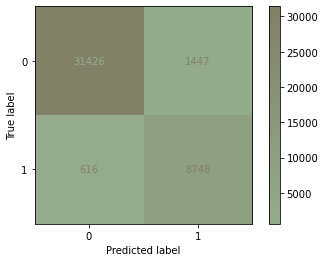

In [117]:
import matplotlib
metrics.plot_confusion_matrix(rf, X_test, y_test,
                             cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", [lighten_color('#94ac8c', 1),lighten_color('#70705a', 0.9)]))

In [119]:
scoring = {'accuracy': 'accuracy',
           'f1':'f1',
           'precision (class 0)': make_scorer(precision_score, average = None, labels = [0]), 
           'precision (class 1)': make_scorer(precision_score, average = None, labels = [1]),
           'recall (class 0)': make_scorer(recall_score, average = None, labels = [0]), 
           'recall (class 1)': make_scorer(recall_score, average = None, labels = [1])}

scores = cross_validate(rf,  X_train_mixed, y_train_mixed, cv=5, scoring=scoring)
scores_to_print = list(scores.keys())[2:]

for k in scores_to_print:
    print('{:19}: {:.2%} (mean), {:.2%} (std)'.format(k.strip("test_"), scores[k].mean(), scores[k].std()))

accuracy           : 87.52% (mean), 3.13% (std)
f1                 : 86.70% (mean), 3.99% (std)
precision (class 0): 88.99% (mean), 6.12% (std)
precision (class 1): 86.50% (mean), 0.24% (std)
recall (class 0)   : 87.73% (mean), 1.29% (std)
recall (class 1)   : 87.30% (mean), 8.01% (std)


In [118]:
print("Score on Training Dataset" + str(rf.score(X_train,y_train)))
print("Score on Test Dataset" + str(rf.score(X_test,y_test)))

Score on Training Dataset0.9527955352612887
Score on Test Dataset0.9511565688851007
